In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
from sklearn.utils import resample 
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing 
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix 
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Pitch Value

In [3]:
mlb_21=pd.read_csv('mlb_21.csv').drop('Unnamed: 0', axis=1)
mlb_20=pd.read_csv('mlb_20.csv').drop('Unnamed: 0', axis=1)
mlb_19=pd.read_csv('mlb_19.csv').drop('Unnamed: 0', axis=1)

In [4]:
concat_data = pd.concat([mlb_21, mlb_20, mlb_19])

In [6]:
data_21 = concat_data[['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'release_pos_y', 'player_name', 'batter', 'pitcher', 'events', 'description', 'zone',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'if_fielding_alignment', 'of_fielding_alignment',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'launch_speed', 'launch_angle', 'release_spin_rate', 'release_extension', 'game_pk',
       'woba_value', 'launch_speed_angle', 'at_bat_number', 'pitch_number', 'pitch_name', 'home_score', 'away_score', 'post_away_score', 'post_home_score',
       'bat_score', 'post_bat_score', 'fld_score', 'delta_home_win_exp', 'delta_run_exp']]

data_21['1b'] = np.where(data_21['on_1b'].notnull(), 1, 0)
data_21['2b'] = np.where(data_21['on_2b'].notnull(), 1, 0)
data_21['3b'] = np.where(data_21['on_3b'].notnull(), 1, 0)
data_21 = data_21.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
data_21['start_state'] = data_21['1b'].astype('str') + data_21['2b'].astype('str') + data_21['3b'].astype('str') + ' ' + data_21['outs_when_up'].astype('str')
data_21['next_state'] = data_21['start_state'].shift(-1)
data_21['next_topbot'] = data_21['inning_topbot'].shift(-1)
data_21['next_game_pk'] = data_21['game_pk'].shift(-1)
data_21['next_state'] = np.where((data_21['inning_topbot']!=data_21['next_topbot'])|
                                 (data_21['next_game_pk']!=data_21['game_pk'])|
                                 (data_21['next_state'].isnull()), '000 3', data_21['next_state'])

data_21['scoring'] = data_21['post_bat_score'] - data_21['bat_score']
score = data_21.groupby(['game_pk', 'inning', 'inning_topbot'])['bat_score'].max().reset_index().rename(columns={'bat_score': 'inning_score'})
data_21 = pd.merge(data_21, score, on=['game_pk', 'inning', 'inning_topbot'])

In [7]:
events = data_21[data_21['events'].notnull()]
events['future_run'] = events['inning_score'] - events['bat_score']
re = events.groupby('start_state')['future_run'].mean().reset_index().rename(columns={'future_run': 're'})
re_0003 = pd.DataFrame([['000 3', 0]], columns=['start_state', 're'])
re = re.append(re_0003)
data_21 = pd.merge(data_21, re, on=['start_state'])
events = pd.merge(events, re, on=['start_state'])

In [8]:
next_re = re.copy().rename(columns={'start_state': 'next_state', 're': 'next_re'})
data_21 = pd.merge(data_21, next_re, on=['next_state'])
data_21 = data_21.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
events = pd.merge(events, next_re, on=['next_state'])

In [9]:
events['run_value'] = events['next_re'].astype('float') - events['re'].astype('float') + events['post_bat_score'].astype('float') - events['bat_score'].astype('float')
at_bat_rv = events[['game_pk', 'at_bat_number', 'run_value']]
data_21 = pd.merge(data_21, at_bat_rv, on=['game_pk', 'at_bat_number'])
event_rv = data_21.groupby('events')['run_value'].mean().reset_index().sort_values(by='run_value', ascending=False).rename(columns={'run_value': 'event_rv'})

In [10]:
data_21 = pd.merge(data_21, event_rv, on='events', how='left')
data_21['count'] = data_21['balls'].astype('str')+'-'+data_21['strikes'].astype('str')
data_21 = data_21[data_21['balls']!=4]
rv_by_count = data_21.groupby(['count'])['run_value'].mean().reset_index().rename(columns={'run_value': 'count_rv'})

In [11]:
rv_by_count

,count,count_rv
0,0-0,-0.002245
1,0-1,-0.048273
2,0-2,-0.107876
3,1-0,0.037359
4,1-1,-0.016626
5,1-2,-0.080583
6,2-0,0.103206
7,2-1,0.033966
8,2-2,-0.039145
9,3-0,0.211333


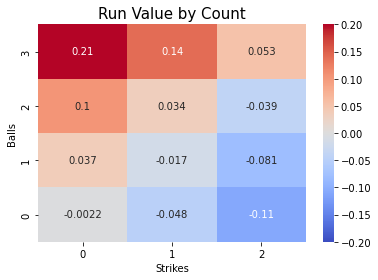

In [12]:
table1 = pd.DataFrame(np.array([rv_by_count['count_rv'][0:3], rv_by_count['count_rv'][3:6], rv_by_count['count_rv'][6:9], rv_by_count['count_rv'][9:12]]),
            columns=['0','1','2'], index=['0','1','2','3'], dtype='float')

sns.heatmap(table1.iloc[::-1], annot=True, cmap='coolwarm', vmin=-0.2, vmax=0.2)
plt.title("Run Value by Count", size=15)
plt.xlabel('Strikes')
plt.ylabel('Balls')
plt.show()

In [13]:
data_21 = pd.merge(data_21, rv_by_count, on='count')
data_21 = data_21.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
data_21['next_count_rv'] = data_21['count_rv'].shift(-1)
data_21['next_count_rv'] = np.where(data_21['events'].isnull(), data_21['next_count_rv'], data_21['event_rv'])

data_21['pitch_value'] = data_21['next_count_rv'] - data_21['count_rv']

In [14]:
df = data_21.copy()

# Ryu Hyun Jin

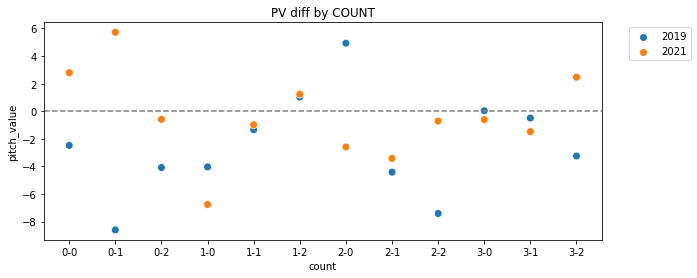

In [15]:
ryu = df[(df['player_name']=='Ryu, Hyun Jin')&(df['game_type']=='R')]
ryu_1921 = ryu[(ryu['game_year']==2019)|(ryu['game_year']==2021)]

ryu_count_pv_1921 = ryu_1921.groupby(['game_year', 'count']).agg({'pitch_value': 'sum', 'pitch_type': 'count'}).reset_index()
plt.figure(figsize=(10,4))
sns.scatterplot(data=ryu_count_pv_1921, x='count', y='pitch_value', hue='game_year', palette='tab10',s=60)
plt.axhline(0, linestyle='--', color='grey')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title('PV diff by COUNT')
plt.show()

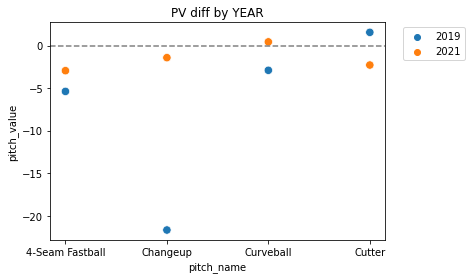

In [16]:
ryu_pitch = ['4-Seam Fastball', 'Cutter', 'Changeup', 'Curveball']
ryu_21_main = ryu_1921[ryu_1921['pitch_name'].isin(ryu_pitch)]
ryu_pitch_pv_21 = ryu_21_main.groupby(['game_year', 'pitch_name']).agg({'pitch_value': 'sum'}).reset_index()
sns.scatterplot(data=ryu_pitch_pv_21, x='pitch_name', y='pitch_value', hue='game_year', palette='tab10', s=70)
plt.axhline(0, linestyle='--', color='grey')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title('PV diff by YEAR')
plt.show()

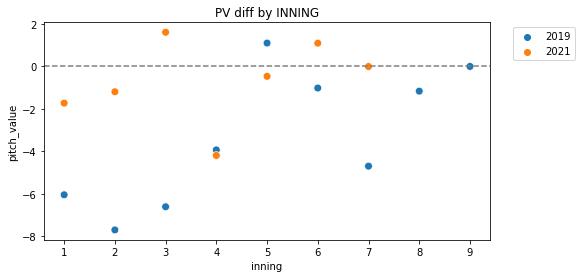

In [17]:
ryu_count_pv_1921 = ryu_1921.groupby(['game_year', 'inning']).agg({'pitch_value': 'sum', 'pitch_type': 'count'}).reset_index()
plt.figure(figsize=(8,4))
sns.scatterplot(data=ryu_count_pv_1921, x='inning', y='pitch_value', hue='game_year', palette='tab10', s=60)
plt.axhline(0, linestyle='--', color='grey')
plt.title('PV diff by INNING')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [18]:
ryu_1921['next_pitch'] = ryu_1921['pitch_name'].shift(-1)
ryu_1921['pre_pitch'] = ryu_1921['pitch_name'].shift(1)
ryu_1921['pre_plate_x'] = ryu_1921['plate_x'].shift(1)
ryu_1921['pre_plate_z'] = ryu_1921['plate_z'].shift(1)
ryu_1921['pre_pfx_x'] = ryu_1921['pfx_x'].shift(1)
ryu_1921['pre_pfx_z'] = ryu_1921['pfx_z'].shift(1)
ryu_1921['pre_release_pos_x'] = ryu_1921['release_pos_x'].shift(1)
ryu_1921['pre_release_pos_z'] = ryu_1921['release_pos_z'].shift(1)

ryu_1921.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,release_pos_y,player_name,batter,pitcher,events,description,zone,game_type,stand,p_throws,home_team,away_team,type,if_fielding_alignment,of_fielding_alignment,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,launch_speed,launch_angle,release_spin_rate,release_extension,game_pk,woba_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,post_away_score,post_home_score,bat_score,post_bat_score,fld_score,delta_home_win_exp,delta_run_exp,1b,2b,3b,start_state,next_state,next_topbot,next_game_pk,scoring,inning_score,re,next_re,run_value,event_rv,count,count_rv,next_count_rv,pitch_value,next_pitch,pre_pitch,pre_plate_x,pre_plate_z,pre_pfx_x,pre_pfx_z,pre_release_pos_x,pre_release_pos_z
2987,FF,2019-06-10,88.8,2.33,6.16,54.6,"Ryu, Hyun Jin",600303,547943,field_out,hit_into_play,1.0,R,L,L,LAA,LAD,X,Infield shift,Standard,5.0,popup,0,0,2019,1.04,1.11,-0.3,3.36,<NA>,<NA>,<NA>,0,1,Bot,131.74,189.74,80.0,69.0,2128.0,5.9,564769,0.0,3.0,4,1,4-Seam Fastball,0,0,0,0,0,0,0,-0.021,-0.248,0,0,0,000 0,000 1,Bot,564769,0,0,0.516596,0.276279,-0.240317,-0.246841,0-0,-0.002245,-0.246841,-0.244596,Curveball,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2988,CU,2019-06-10,73.3,2.24,6.15,55.16,"Ryu, Hyun Jin",545361,547943,NaN,ball,7.0,R,R,L,LAA,LAD,B,Infield shift,Standard,<NA>,NaN,0,0,2019,-1.08,-1.06,-0.66,1.82,<NA>,<NA>,<NA>,1,1,Bot,NaN,NaN,NaN,<NA>,2624.0,5.3,564769,NaN,<NA>,5,1,Curveball,0,0,0,0,0,0,0,0.0,0.028,0,0,0,000 1,000 1,Bot,564769,0,0,0.276279,0.276279,-0.171260,NaN,0-0,-0.002245,0.037359,0.039604,Cutter,4-Seam Fastball,-0.3,3.36,1.04,1.11,2.33,6.16
1251836,FC,2019-06-10,87.6,2.38,6.18,54.66,"Ryu, Hyun Jin",545361,547943,NaN,called_strike,1.0,R,R,L,LAA,LAD,S,Infield shift,Standard,<NA>,NaN,1,0,2019,0.23,1.15,-0.5,3.17,<NA>,<NA>,<NA>,1,1,Bot,NaN,NaN,NaN,<NA>,2158.0,5.8,564769,NaN,<NA>,5,2,Cutter,0,0,0,0,0,0,0,0.0,-0.037,0,0,0,000 1,000 1,Bot,564769,0,0,0.276279,0.276279,-0.171260,NaN,1-0,0.037359,-0.016626,-0.053985,4-Seam Fastball,Curveball,-0.66,1.82,-1.08,-1.06,2.24,6.15
905573,FF,2019-06-10,91.0,2.58,5.99,54.35,"Ryu, Hyun Jin",545361,547943,NaN,foul,2.0,R,R,L,LAA,LAD,S,Infield shift,Standard,<NA>,NaN,1,1,2019,1.03,1.34,0.01,3.17,<NA>,<NA>,<NA>,1,1,Bot,NaN,NaN,NaN,<NA>,2094.0,6.1,564769,NaN,<NA>,5,3,4-Seam Fastball,0,0,0,0,0,0,0,0.0,-0.044,0,0,0,000 1,000 1,Bot,564769,0,0,0.276279,0.276279,-0.171260,NaN,1-1,-0.016626,-0.080583,-0.063957,Changeup,Cutter,-0.5,3.17,0.23,1.15,2.38,6.18
1701418,CH,2019-06-10,79.0,2.59,5.85,53.32,"Ryu, Hyun Jin",545361,547943,NaN,ball,14.0,R,R,L,LAA,LAD,B,Standard,Standard,<NA>,NaN,1,2,2019,1.01,0.7,1.4,1.63,<NA>,<NA>,<NA>,1,1,Bot,NaN,NaN,NaN,<NA>,1457.0,7.2,564769,NaN,<NA>,5,4,Changeup,0,0,0,0,0,0,0,0.0,0.031,0,0,0,000 1,000 1,Bot,564769,0,0,0.276279,0.276279,-0.171260,NaN,1-2,-0.080583,-0.039145,0.041439,Changeup,4-Seam Fastball,0.01,3.17,1.03,1.34,2.58,5.99


# 체인지업

In [19]:
swing = ['foul', 'swinging_strike', 'hit_into_play', 'swinging_strike_blocked', 'foul_bunt', 'foul_tip']
miss = ['swinging_strike', 'swinging_strike_blocked', 'foul_tip']
in_zone = [1,2,3,4,5,6,7,8,9]

ch = ryu_1921[ryu_1921['pitch_name']=='Changeup']

ch['swing'] = np.where(ch['description'].isin(swing),1,0)
ch['swing_str'] = np.where(ch['description'].isin(swing), 'swing', 'no_swing')
ch['miss'] = np.where(ch['description'].isin(miss),1,0)
ch['miss_str'] = np.where(ch['description'].isin(miss), 'miss', 'contact')
ch['called_strike'] = np.where(ch['description']=='called_strike',1,0)
ch['ball'] = np.where((ch['description']=='ball')|(ch['description']=='blocked_ball'),1,0)
ch['year'] = ch['game_year'].astype('str')

ch['in_zone'] = np.where(ch['zone'].isin(in_zone), 1, 0)
ch['out_zone'] = np.where(ch['zone'].isin(in_zone), 0, 1)
ch['z_swing'] = np.where((ch['description'].isin(swing))&(ch['in_zone']==1),1,0)
ch['o_swing'] = np.where((ch['description'].isin(swing))&(ch['out_zone']==1),1,0)
ch['z_miss'] = np.where((ch['description'].isin(miss))&(ch['in_zone']==1),1,0)
ch['o_miss'] = np.where((ch['description'].isin(miss))&(ch['out_zone']==1),1,0)

ch_19 = ch[ch['game_year']==2019]
ch_21 = ch[ch['game_year']==2021]

ch_r = ch[ch['stand']=='R']
ch_l = ch[ch['stand']=='L']

ch_r_19 = ch_r[ch_r['game_year']==2019]
ch_r_21 = ch_r[ch_r['game_year']==2021]
ch_l_19 = ch_l[ch_l['game_year']==2019]
ch_l_21 = ch_l[ch_l['game_year']==2021]

In [20]:
total_count = ryu_1921.groupby(['game_year'])['pitch_type'].count().reset_index().rename(columns={'pitch_type': 'total'})
pitch_count = ryu_1921.groupby(['game_year', 'pitch_name'])['pitch_type'].count().reset_index().rename(columns={'pitch_type': 'count'})
pitch_selection = pd.merge(pitch_count, total_count, on='game_year')
pitch_selection['pitch %'] = round(pitch_selection['count']/pitch_selection['total'],2)
ch_selection = pitch_selection[pitch_selection['pitch_name']=='Changeup'][['game_year', 'pitch_name', 'count', 'pitch %']]
ch_stuff = ch.groupby(['game_year']).agg({'release_speed': 'mean', 'release_spin_rate': 'mean', 'pitch_value': 'sum'}).reset_index()

round(pd.merge(ch_selection, ch_stuff, on='game_year'),2)

,game_year,pitch_name,count,pitch %,release_speed,release_spin_rate,pitch_value
0,2019,Changeup,743,0.27,80.03,1487.14,-21.67
1,2021,Changeup,684,0.25,79.88,1510.85,-1.42


In [21]:
ch_event_19 = ch_19['events'].value_counts().reset_index().rename(columns={'events': 'events_19'})
ch_event_21 = ch_21['events'].value_counts().reset_index().rename(columns={'events': 'events_21'})
ch_event_total = pd.merge(ch_event_19,ch_event_21, on='index')
ch_event_total['diff'] = ch_event_total['events_21'] - ch_event_total['events_19']
#ch_event_total['% 19'] = ch_event_total['events_19']/743
#ch_event_total['% 21'] = ch_event_total['events_21']/684
#ch_event_total['% diff'] = ch_event_total['% 21'] - ch_event_total['% 19']
ch_event_total['abs_diff'] = abs(ch_event_total['diff'])
round(ch_event_total.sort_values(by='abs_diff', ascending=False)[['index', 'events_19', 'events_21', 'diff']].rename(columns={'index': 'event',
                                                                                                                             'events_19': '2019',
                                                                                                                             'events_21': '2021'}),2)

,event,2019,2021,diff
0,field_out,133,104,-29
1,strikeout,52,32,-20
6,walk,6,13,7
4,grounded_into_double_play,8,4,-4
3,double,11,14,3
5,force_out,7,9,2
7,home_run,5,6,1
8,field_error,3,2,-1
2,single,32,32,0


# 삼진

In [24]:
s2 = ch[ch['strikes']==2]
s2_all = s2.groupby(['game_year']).agg({'pitch_type': 'count',
                                        'in_zone': 'sum',
                                        'out_zone': 'sum',
                                        'swing': 'sum', 
                                        'miss': 'sum', 
                                        'z_swing': 'sum', 
                                        'z_miss': 'sum',
                                        'o_swing': 'sum', 
                                        'o_miss': 'sum',
                                        'called_strike': 'sum', 
                                        'ball': 'sum', 
                                        'pitch_value': 'sum'}).reset_index().rename(columns={'pitch_type': 'total'})
s2_all['swing %'] = round(s2_all['swing']/s2_all['total'],3)
s2_all['whiff %'] = round(s2_all['miss']/s2_all['swing'],3)
s2_all['z_swing %'] = round(s2_all['z_swing']/s2_all['in_zone'],3)
s2_all['z_whiff %'] = round(s2_all['z_miss']/s2_all['z_swing'],3)
s2_all['o_swing %'] = round(s2_all['o_swing']/s2_all['out_zone'],3)
s2_all['o_whiff %'] = round(s2_all['o_miss']/s2_all['o_swing'],3)

s2_all.sort_values(by=['game_year']).drop(['called_strike', 'in_zone', 'out_zone', 'z_swing', 'z_miss', 'o_swing', 'o_miss'], axis=1)

,game_year,total,swing,miss,ball,pitch_value,swing %,whiff %,z_swing %,z_whiff %,o_swing %,o_whiff %
0,2019,243,185,46,52,-13.116166,0.761,0.249,0.944,0.176,0.654,0.310
1,2021,227,159,29,65,4.021125,0.700,0.182,0.955,0.062,0.594,0.263


In [100]:
s2 = ch[ch['strikes']==2]
s2_pre = s2.groupby(['game_year', 'pre_pitch']).agg({'pitch_type': 'count',
                                        'in_zone': 'sum',
                                        'out_zone': 'sum',
                                        'swing': 'sum', 
                                        'miss': 'sum', 
                                        'z_swing': 'sum', 
                                        'z_miss': 'sum',
                                        'o_swing': 'sum', 
                                        'o_miss': 'sum',
                                        'called_strike': 'sum', 
                                        'ball': 'sum', 
                                        'pitch_value': 'sum'}).reset_index().rename(columns={'pitch_type': 'total'})
s2_pre['swing %'] = round(s2_pre['swing']/s2_pre['total'],3)
s2_pre['whiff %'] = round(s2_pre['miss']/s2_pre['swing'],3)
s2_pre['z_swing %'] = round(s2_pre['z_swing']/s2_pre['in_zone'],3)
s2_pre['z_whiff %'] = round(s2_pre['z_miss']/s2_pre['z_swing'],3)
s2_pre['o_swing %'] = round(s2_pre['o_swing']/s2_pre['out_zone'],3)
s2_pre['o_whiff %'] = round(s2_pre['o_miss']/s2_pre['o_swing'],3)

round(s2_pre.sort_values(by=['pre_pitch', 'game_year']).drop(['ball', 'called_strike', 'swing %', 'in_zone', 'out_zone', 'z_swing', 'z_miss', 'o_swing', 'o_miss'], axis=1),3)

,game_year,pre_pitch,total,swing,miss,pitch_value,whiff %,z_swing %,z_whiff %,o_swing %,o_whiff %
0,2019,4-Seam Fastball,83,62,15,-3.153,0.242,0.941,0.125,0.612,0.367
6,2021,4-Seam Fastball,63,39,6,4.712,0.154,1.000,0.000,0.489,0.261
1,2019,Changeup,64,50,11,-5.519,0.220,0.952,0.150,0.698,0.267
7,2021,Changeup,58,45,14,-3.049,0.311,0.857,0.167,0.730,0.407
2,2019,Curveball,21,16,5,-0.336,0.312,0.833,0.400,0.733,0.273
8,2021,Curveball,26,15,1,2.873,0.067,1.000,0.143,0.421,0.000
3,2019,Cutter,60,47,12,-3.569,0.255,0.960,0.208,0.657,0.304
9,2021,Cutter,76,57,8,-1.171,0.140,1.000,0.000,0.655,0.222
4,2019,Sinker,13,8,3,-0.538,0.375,1.000,0.500,0.545,0.333
5,2019,Slider,2,2,0,0.000,0.000,1.000,0.000,NaN,NaN


In [26]:
s2_pre_fast = s2[(s2['pre_pitch']=='4-Seam Fastball')|(s2['pre_pitch']=='Cutter')].groupby(['game_year']).agg({'pitch_type': 'count',
                                        'in_zone': 'sum',
                                        'out_zone': 'sum',
                                        'swing': 'sum', 
                                        'miss': 'sum', 
                                        'z_swing': 'sum', 
                                        'z_miss': 'sum',
                                        'o_swing': 'sum', 
                                        'o_miss': 'sum',
                                        'called_strike': 'sum', 
                                        'ball': 'sum', 
                                        'pitch_value': 'sum'}).reset_index().rename(columns={'pitch_type': 'total'})
s2_pre_fast['swing %'] = round(s2_pre_fast['swing']/s2_pre_fast['total'],3)
s2_pre_fast['whiff %'] = round(s2_pre_fast['miss']/s2_pre_fast['swing'],3)
s2_pre_fast['z_swing %'] = round(s2_pre_fast['z_swing']/s2_pre_fast['in_zone'],3)
s2_pre_fast['z_whiff %'] = round(s2_pre_fast['z_miss']/s2_pre_fast['z_swing'],3)
s2_pre_fast['o_swing %'] = round(s2_pre_fast['o_swing']/s2_pre_fast['out_zone'],3)
s2_pre_fast['o_whiff %'] = round(s2_pre_fast['o_miss']/s2_pre_fast['o_swing'],3)

s2_pre_fast.sort_values(by=['game_year']).drop(['in_zone', 'out_zone', 'z_swing', 'z_miss', 'o_swing', 'o_miss'], axis=1)

,game_year,total,swing,miss,called_strike,ball,pitch_value,swing %,whiff %,z_swing %,z_whiff %,o_swing %,o_whiff %
0,2019,143,109,27,3,31,-6.722817,0.762,0.248,0.949,0.161,0.631,0.340
1,2021,139,96,14,0,43,3.541673,0.691,0.146,1.000,0.000,0.578,0.237


In [27]:
s2_pre_ff = s2[s2['pre_pitch']=='4-Seam Fastball']
s2_pre_ff_19 = s2_pre_ff[s2_pre_ff['game_year']==2019]
s2_pre_ff_21 = s2_pre_ff[s2_pre_ff['game_year']==2021]

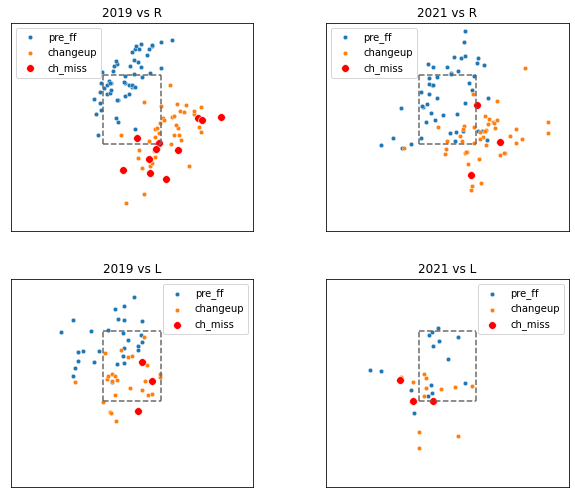

In [28]:
L=-0.8333
R=0.8333
TOP=3.5
BOT=1.5

fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(ncols=2, nrows=2, figsize=(10,9))
plt.subplots_adjust(wspace=0.3, hspace=0.1)

sns.scatterplot(ax=ax1,data=s2_pre_ff_19[s2_pre_ff_19['stand']=='R'], x='pre_plate_x', y='pre_plate_z', label='pre_ff', s=20)
sns.scatterplot(ax=ax1,data=s2_pre_ff_19[s2_pre_ff_19['stand']=='R'], x='plate_x', y='plate_z', label='changeup', s=20)
sns.scatterplot(ax=ax1,data=s2_pre_ff_19[(s2_pre_ff_19['stand']=='R')&(s2_pre_ff_19['miss']==1)], x='plate_x', y='plate_z', label='ch_miss', s=60, color='red')
ax1.vlines([L,R], BOT, TOP, colors='dimgray', linestyles='--', label='Strike Zone')
ax1.hlines([BOT,TOP], L, R, linestyles='--', colors='dimgray')
ax1.set_xlim(-3.5, 3.5)
ax1.set_ylim(-1, 5)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title('2019 vs R')
ax1.set_aspect('equal')

sns.scatterplot(ax=ax2,data=s2_pre_ff_21[s2_pre_ff_21['stand']=='R'], x='pre_plate_x', y='pre_plate_z', label='pre_ff', s=20)
sns.scatterplot(ax=ax2,data=s2_pre_ff_21[s2_pre_ff_21['stand']=='R'], x='plate_x', y='plate_z', label='changeup', s=20)
sns.scatterplot(ax=ax2,data=s2_pre_ff_21[(s2_pre_ff_21['stand']=='R')&(s2_pre_ff_21['miss']==1)], x='plate_x', y='plate_z', label='ch_miss', s=60, color='red')
ax2.vlines([L,R], BOT, TOP, colors='dimgray', linestyles='--', label='Strike Zone')
ax2.hlines([BOT,TOP], L, R, linestyles='--', colors='dimgray')
ax2.set_xlim(-3.5, 3.5)
ax2.set_ylim(-1, 5)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title('2021 vs R')
ax2.set_aspect('equal')

sns.scatterplot(ax=ax3,data=s2_pre_ff_19[s2_pre_ff_19['stand']=='L'], x='pre_plate_x', y='pre_plate_z', label='pre_ff', s=20)
sns.scatterplot(ax=ax3,data=s2_pre_ff_19[s2_pre_ff_19['stand']=='L'], x='plate_x', y='plate_z', label='changeup', s=20)
sns.scatterplot(ax=ax3,data=s2_pre_ff_19[(s2_pre_ff_19['stand']=='L')&(s2_pre_ff_19['miss']==1)], x='plate_x', y='plate_z', label='ch_miss', s=60, color='red')
ax3.vlines([L,R], BOT, TOP, colors='dimgray', linestyles='--', label='Strike Zone')
ax3.hlines([BOT,TOP], L, R, linestyles='--', colors='dimgray')
ax3.set_xlim(-3.5, 3.5)
ax3.set_ylim(-1, 5)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.set_title('2019 vs L')
ax3.set_aspect('equal')

sns.scatterplot(ax=ax4,data=s2_pre_ff_21[s2_pre_ff_21['stand']=='L'], x='pre_plate_x', y='pre_plate_z', label='pre_ff', s=20)
sns.scatterplot(ax=ax4,data=s2_pre_ff_21[s2_pre_ff_21['stand']=='L'], x='plate_x', y='plate_z', label='changeup', s=20)
sns.scatterplot(ax=ax4,data=s2_pre_ff_21[(s2_pre_ff_21['stand']=='L')&(s2_pre_ff_21['miss']==1)], x='plate_x', y='plate_z', label='ch_miss', s=60, color='red')
ax4.vlines([L,R], BOT, TOP, colors='dimgray', linestyles='--', label='Strike Zone')
ax4.hlines([BOT,TOP], L, R, linestyles='--', colors='dimgray')
ax4.set_xlim(-3.5, 3.5)
ax4.set_ylim(-1, 5)
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax4.set_title('2021 vs L')
ax4.set_aspect('equal')

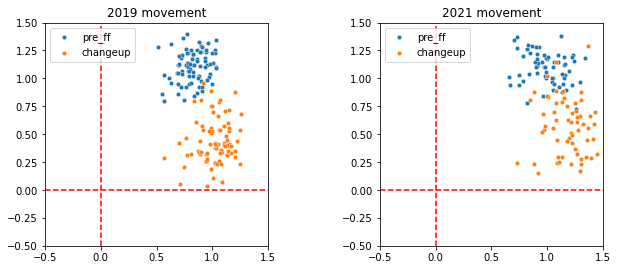

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,8))
plt.subplots_adjust(wspace=0.5)

sns.scatterplot(ax=ax1,data=s2_pre_ff_19, x='pre_pfx_x', y='pre_pfx_z', label='pre_ff', s=20)
sns.scatterplot(ax=ax1,data=s2_pre_ff_19, x='pfx_x', y='pfx_z', label='changeup', s=20)
#sns.scatterplot(ax=ax1,data=s2_pre_ff_19[s2_pre_ff_19['miss']==1], x='pfx_x', y='pfx_z', label='miss')
ax1.vlines(0,-0.5,1.5, colors='r', linestyles='--')
ax1.hlines(0,-0.5,1.5, linestyles='--', colors='r')
ax1.set_xlim(-0.5, 1.5)
ax1.set_ylim(-0.5, 1.5)
ax1.set_title('2019 movement')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_aspect('equal')

sns.scatterplot(ax=ax2,data=s2_pre_ff_21, x='pre_pfx_x', y='pre_pfx_z', label='pre_ff', s=20)
sns.scatterplot(ax=ax2,data=s2_pre_ff_21, x='pfx_x', y='pfx_z', label='changeup', s=20)
#sns.scatterplot(ax=ax2,data=s2_pre_ff_21[s2_pre_ff_21['miss']==1], x='pfx_x', y='pfx_z', label='miss')
ax2.set_xlim(-0.5, 1.5)
ax2.set_ylim(-0.5, 1.5)
ax2.vlines(0,-0.5,1.5, colors='r', linestyles='--')
ax2.hlines(0,-0.5,1.5, linestyles='--', colors='r')
ax2.set_title('2021 movement')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_aspect('equal')


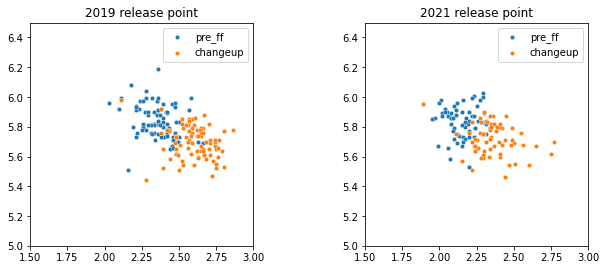

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,8))
plt.subplots_adjust(wspace=0.5)

sns.scatterplot(ax=ax1,data=s2_pre_ff_19, x='pre_release_pos_x', y='pre_release_pos_z', label='pre_ff', s=20)
sns.scatterplot(ax=ax1,data=s2_pre_ff_19, x='release_pos_x', y='release_pos_z', label='changeup', s=20)
#sns.scatterplot(ax=ax1,data=s2_pre_ff_19[s2_pre_ff_19['miss']==1], x='release_pos_x', y='release_pos_z', label='miss')
ax1.set_xlim(1.5, 3)
ax1.set_ylim(5, 6.5)
ax1.set_title('2019 release point')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_aspect('equal')

sns.scatterplot(ax=ax2,data=s2_pre_ff_21, x='pre_release_pos_x', y='pre_release_pos_z', label='pre_ff', s=20)
sns.scatterplot(ax=ax2,data=s2_pre_ff_21, x='release_pos_x', y='release_pos_z', label='changeup', s=20)
#sns.scatterplot(ax=ax2,data=s2_pre_ff_21[s2_pre_ff_21['miss']==1], x='release_pos_x', y='release_pos_z', label='miss')
ax2.set_xlim(1.5, 3)
ax2.set_ylim(5, 6.5)
ax2.set_title('2021 release point')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_aspect('equal')

In [31]:
s2_pre_ct = s2[s2['pre_pitch']=='Cutter']
s2_pre_ct_19 = s2_pre_ct[s2_pre_ct['game_year']==2019]
s2_pre_ct_21 = s2_pre_ct[s2_pre_ct['game_year']==2021]

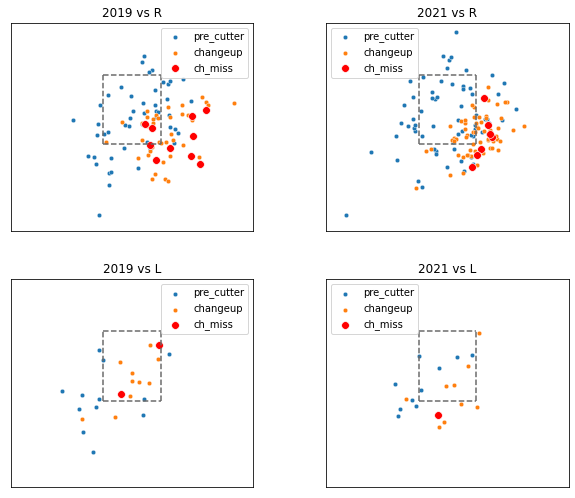

In [32]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(ncols=2, nrows=2, figsize=(10,9))
plt.subplots_adjust(wspace=0.3, hspace=0.1)

sns.scatterplot(ax=ax1,data=s2_pre_ct_19[s2_pre_ct_19['stand']=='R'], x='pre_plate_x', y='pre_plate_z', label='pre_cutter', s=20)
sns.scatterplot(ax=ax1,data=s2_pre_ct_19[s2_pre_ct_19['stand']=='R'], x='plate_x', y='plate_z', label='changeup', s=20)
sns.scatterplot(ax=ax1,data=s2_pre_ct_19[(s2_pre_ct_19['stand']=='R')&(s2_pre_ct_19['miss']==1)], x='plate_x', y='plate_z', label='ch_miss', s=60, color='red')
ax1.vlines([L,R], BOT, TOP, colors='dimgray', linestyles='--', label='Strike Zone')
ax1.hlines([BOT,TOP], L, R, linestyles='--', colors='dimgray')
ax1.set_xlim(-3.5, 3.5)
ax1.set_ylim(-1, 5)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title('2019 vs R')
ax1.set_aspect('equal')

sns.scatterplot(ax=ax2,data=s2_pre_ct_21[s2_pre_ct_21['stand']=='R'], x='pre_plate_x', y='pre_plate_z', label='pre_cutter', s=20)
sns.scatterplot(ax=ax2,data=s2_pre_ct_21[s2_pre_ct_21['stand']=='R'], x='plate_x', y='plate_z', label='changeup', s=20)
sns.scatterplot(ax=ax2,data=s2_pre_ct_21[(s2_pre_ct_21['stand']=='R')&(s2_pre_ct_21['miss']==1)], x='plate_x', y='plate_z', label='ch_miss', s=60, color='red')
ax2.vlines([L,R], BOT, TOP, colors='dimgray', linestyles='--', label='Strike Zone')
ax2.hlines([BOT,TOP], L, R, linestyles='--', colors='dimgray')
ax2.set_xlim(-3.5, 3.5)
ax2.set_ylim(-1, 5)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title('2021 vs R')
ax2.set_aspect('equal')


sns.scatterplot(ax=ax3,data=s2_pre_ct_19[s2_pre_ct_19['stand']=='L'], x='pre_plate_x', y='pre_plate_z', label='pre_cutter', s=20)
sns.scatterplot(ax=ax3,data=s2_pre_ct_19[s2_pre_ct_19['stand']=='L'], x='plate_x', y='plate_z', label='changeup', s=20)
sns.scatterplot(ax=ax3,data=s2_pre_ct_19[(s2_pre_ct_19['stand']=='L')&(s2_pre_ct_19['miss']==1)], x='plate_x', y='plate_z', label='ch_miss', s=60, color='red')
ax3.vlines([L,R], BOT, TOP, colors='dimgray', linestyles='--', label='Strike Zone')
ax3.hlines([BOT,TOP], L, R, linestyles='--', colors='dimgray')
ax3.set_xlim(-3.5, 3.5)
ax3.set_ylim(-1, 5)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.set_title('2019 vs L')
ax3.set_aspect('equal')

sns.scatterplot(ax=ax4,data=s2_pre_ct_21[s2_pre_ct_21['stand']=='L'], x='pre_plate_x', y='pre_plate_z', label='pre_cutter', s=20)
sns.scatterplot(ax=ax4,data=s2_pre_ct_21[s2_pre_ct_21['stand']=='L'], x='plate_x', y='plate_z', label='changeup', s=20)
sns.scatterplot(ax=ax4,data=s2_pre_ct_21[(s2_pre_ct_21['stand']=='L')&(s2_pre_ct_21['miss']==1)], x='plate_x', y='plate_z', label='ch_miss', s=60, color='red')
ax4.vlines([L,R], BOT, TOP, colors='dimgray', linestyles='--', label='Strike Zone')
ax4.hlines([BOT,TOP], L, R, linestyles='--', colors='dimgray')
ax4.set_xlim(-3.5, 3.5)
ax4.set_ylim(-1, 5)
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax4.set_title('2021 vs L')
ax4.set_aspect('equal')



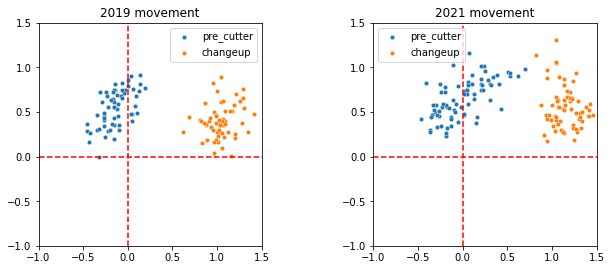

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,8))
plt.subplots_adjust(wspace=0.5)

sns.scatterplot(ax=ax1,data=s2_pre_ct_19, x='pre_pfx_x', y='pre_pfx_z', label='pre_cutter', s=20)
sns.scatterplot(ax=ax1,data=s2_pre_ct_19, x='pfx_x', y='pfx_z', label='changeup', s=20)

ax1.vlines(0,-1,1.5, colors='r', linestyles='--')
ax1.hlines(0,-1,1.5, linestyles='--', colors='r')
ax1.set_xlim(-1, 1.5)
ax1.set_ylim(-1, 1.5)
ax1.set_title('2019 movement')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_aspect('equal')


sns.scatterplot(ax=ax2,data=s2_pre_ct_21, x='pre_pfx_x', y='pre_pfx_z', label='pre_cutter', s=20)
sns.scatterplot(ax=ax2,data=s2_pre_ct_21, x='pfx_x', y='pfx_z', label='changeup', s=20)

ax2.set_xlim(-1, 1.5)
ax2.set_ylim(-1, 1.5)
ax2.vlines(0,-1,1.5, colors='r', linestyles='--')
ax2.hlines(0,-1,1.5, linestyles='--', colors='r')
ax2.set_title('2021 movement')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_aspect('equal')

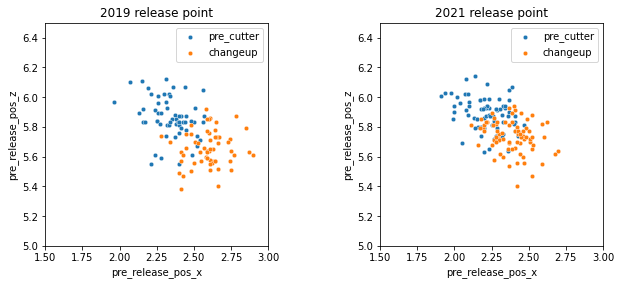

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,8))
plt.subplots_adjust(wspace=0.5)

sns.scatterplot(ax=ax1,data=s2_pre_ct_19, x='pre_release_pos_x', y='pre_release_pos_z', label='pre_cutter', s=20)
sns.scatterplot(ax=ax1,data=s2_pre_ct_19, x='release_pos_x', y='release_pos_z', label='changeup', s=20)

ax1.set_xlim(1.5, 3)
ax1.set_ylim(5, 6.5)
ax1.set_title('2019 release point')
ax1.set_aspect('equal')

sns.scatterplot(ax=ax2,data=s2_pre_ct_21, x='pre_release_pos_x', y='pre_release_pos_z', label='pre_cutter', s=20)
sns.scatterplot(ax=ax2,data=s2_pre_ct_21, x='release_pos_x', y='release_pos_z', label='changeup', s=20)

ax2.set_xlim(1.5, 3)
ax2.set_ylim(5, 6.5)
ax2.set_title('2021 release point')
ax2.set_aspect('equal')

In [35]:
s2_pre_cb = s2[s2['pre_pitch']=='Curveball']
s2_pre_cb_19 = s2_pre_cb[s2_pre_cb['game_year']==2019]
s2_pre_cb_21 = s2_pre_cb[s2_pre_cb['game_year']==2021]

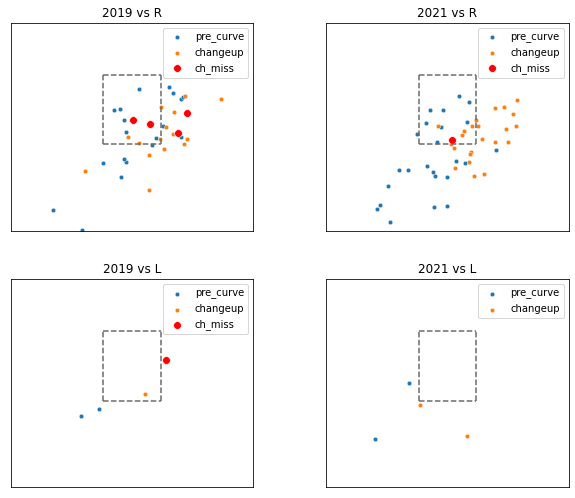

In [36]:
fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(ncols=2, nrows=2, figsize=(10,9))
plt.subplots_adjust(wspace=0.3, hspace=0.1)

sns.scatterplot(ax=ax1,data=s2_pre_cb_19[s2_pre_cb_19['stand']=='R'], x='pre_plate_x', y='pre_plate_z', label='pre_curve', s=20)
sns.scatterplot(ax=ax1,data=s2_pre_cb_19[s2_pre_cb_19['stand']=='R'], x='plate_x', y='plate_z', label='changeup', s=20)
sns.scatterplot(ax=ax1,data=s2_pre_cb_19[(s2_pre_cb_19['stand']=='R')&(s2_pre_cb_19['miss']==1)], x='plate_x', y='plate_z', label='ch_miss', s=60, color='red')
ax1.vlines([L,R], BOT, TOP, colors='dimgray', linestyles='--', label='Strike Zone')
ax1.hlines([BOT,TOP], L, R, linestyles='--', colors='dimgray')
ax1.set_xlim(-3.5, 3.5)
ax1.set_ylim(-1, 5)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title('2019 vs R')
ax1.set_aspect('equal')

sns.scatterplot(ax=ax2,data=s2_pre_cb_21[s2_pre_cb_21['stand']=='R'], x='pre_plate_x', y='pre_plate_z', label='pre_curve', s=20)
sns.scatterplot(ax=ax2,data=s2_pre_cb_21[s2_pre_cb_21['stand']=='R'], x='plate_x', y='plate_z', label='changeup', s=20)
sns.scatterplot(ax=ax2,data=s2_pre_cb_21[(s2_pre_cb_21['stand']=='R')&(s2_pre_cb_21['miss']==1)], x='plate_x', y='plate_z', label='ch_miss', s=60, color='red')
ax2.vlines([L,R], BOT, TOP, colors='dimgray', linestyles='--', label='Strike Zone')
ax2.hlines([BOT,TOP], L, R, linestyles='--', colors='dimgray')
ax2.set_xlim(-3.5, 3.5)
ax2.set_ylim(-1, 5)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title('2021 vs R')
ax2.set_aspect('equal')


sns.scatterplot(ax=ax3,data=s2_pre_cb_19[s2_pre_cb_19['stand']=='L'], x='pre_plate_x', y='pre_plate_z', label='pre_curve', s=20)
sns.scatterplot(ax=ax3,data=s2_pre_cb_19[s2_pre_cb_19['stand']=='L'], x='plate_x', y='plate_z', label='changeup', s=20)
sns.scatterplot(ax=ax3,data=s2_pre_cb_19[(s2_pre_cb_19['stand']=='L')&(s2_pre_cb_19['miss']==1)], x='plate_x', y='plate_z', label='ch_miss', s=60, color='red')
ax3.vlines([L,R], BOT, TOP, colors='dimgray', linestyles='--', label='Strike Zone')
ax3.hlines([BOT,TOP], L, R, linestyles='--', colors='dimgray')
ax3.set_xlim(-3.5, 3.5)
ax3.set_ylim(-1, 5)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax3.set_title('2019 vs L')
ax3.set_aspect('equal')

sns.scatterplot(ax=ax4,data=s2_pre_cb_21[s2_pre_cb_21['stand']=='L'], x='pre_plate_x', y='pre_plate_z', label='pre_curve', s=20)
sns.scatterplot(ax=ax4,data=s2_pre_cb_21[s2_pre_cb_21['stand']=='L'], x='plate_x', y='plate_z', label='changeup', s=20)
sns.scatterplot(ax=ax4,data=s2_pre_cb_21[(s2_pre_cb_21['stand']=='L')&(s2_pre_cb_21['miss']==1)], x='plate_x', y='plate_z', label='ch_miss', s=60, color='red')
ax4.vlines([L,R], BOT, TOP, colors='dimgray', linestyles='--', label='Strike Zone')
ax4.hlines([BOT,TOP], L, R, linestyles='--', colors='dimgray')
ax4.set_xlim(-3.5, 3.5)
ax4.set_ylim(-1, 5)
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax4.set_title('2021 vs L')
ax4.set_aspect('equal')

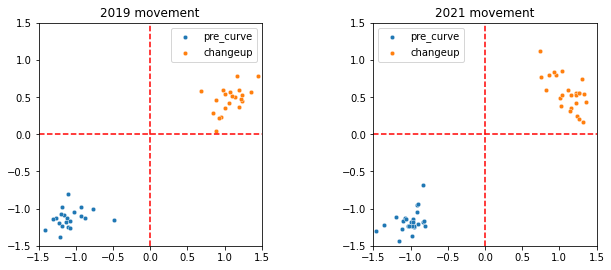

In [37]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,8))
plt.subplots_adjust(wspace=0.5)

sns.scatterplot(ax=ax1,data=s2_pre_cb_19, x='pre_pfx_x', y='pre_pfx_z', label='pre_curve', s=20)
sns.scatterplot(ax=ax1,data=s2_pre_cb_19, x='pfx_x', y='pfx_z', label='changeup', s=20)

ax1.vlines(0,-1.5,1.5, colors='r', linestyles='--')
ax1.hlines(0,-1.5,1.5, linestyles='--', colors='r')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_title('2019 movement')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_aspect('equal')


sns.scatterplot(ax=ax2,data=s2_pre_cb_21, x='pre_pfx_x', y='pre_pfx_z', label='pre_curve', s=20)
sns.scatterplot(ax=ax2,data=s2_pre_cb_21, x='pfx_x', y='pfx_z', label='changeup', s=20)

ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)
ax2.vlines(0,-1.5,1.5, colors='r', linestyles='--')
ax2.hlines(0,-1.5,1.5, linestyles='--', colors='r')
ax2.set_title('2021 movement')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_aspect('equal')

In [38]:
s2['pre_pitch'].value_counts()

4-Seam Fastball    146
Cutter             136
Changeup           122
Curveball           47
Sinker              13
Slider               6
Name: pre_pitch, dtype: int64

In [39]:
s2_count = s2.groupby(['game_year', 'count']).agg({'pitch_type': 'count',
                                        'in_zone': 'sum',
                                        'out_zone': 'sum',
                                        'swing': 'sum', 
                                        'miss': 'sum', 
                                        'z_swing': 'sum', 
                                        'z_miss': 'sum',
                                        'o_swing': 'sum', 
                                        'o_miss': 'sum',
                                        'called_strike': 'sum', 
                                        'ball': 'sum', 
                                        'pitch_value': 'sum'}).reset_index().rename(columns={'pitch_type': 'total'})
s2_count['swing %'] = round(s2_count['swing']/s2_count['total'],3)
s2_count['whiff %'] = round(s2_count['miss']/s2_count['swing'],3)
s2_count['z_swing %'] = round(s2_count['z_swing']/s2_count['in_zone'],3)
s2_count['z_whiff %'] = round(s2_count['z_miss']/s2_count['z_swing'],3)
s2_count['o_swing %'] = round(s2_count['o_swing']/s2_count['out_zone'],3)
s2_count['o_whiff %'] = round(s2_count['o_miss']/s2_count['o_swing'],3)
s2_count.sort_values(by=['count', 'game_year']).drop(['in_zone', 'out_zone', 'z_swing', 'z_miss', 'o_swing', 'o_miss'], axis=1)

,game_year,count,total,swing,miss,called_strike,ball,pitch_value,swing %,whiff %,z_swing %,z_whiff %,o_swing %,o_whiff %
0,2019,0-2,49,34,12,0,15,-2.488899,0.694,0.353,1.000,0.273,0.605,0.391
4,2021,0-2,49,29,7,0,20,-1.235803,0.592,0.241,1.000,0.125,0.512,0.286
1,2019,1-2,69,47,12,1,21,-1.914297,0.681,0.255,0.950,0.211,0.571,0.286
5,2021,1-2,72,41,11,2,29,1.694846,0.569,0.268,0.889,0.000,0.463,0.440
2,2019,2-2,88,70,18,5,13,-7.599948,0.795,0.257,0.889,0.188,0.731,0.316
6,2021,2-2,73,62,9,1,10,-0.842819,0.849,0.145,0.957,0.091,0.800,0.175
3,2019,3-2,37,34,4,0,3,-1.113022,0.919,0.118,1.000,0.087,0.786,0.182
7,2021,3-2,33,27,2,0,6,4.404900,0.818,0.074,1.000,0.056,0.600,0.111


# 필드 아웃

In [40]:
hip = ch[ch['description']=='hit_into_play']
hip['ground_ball'] = np.where(hip['bb_type']=='ground_ball', 1, 0)
hip['fly_ball'] = np.where(hip['bb_type']=='fly_ball', 1, 0)
hip['line_drive'] = np.where(hip['bb_type']=='line_drive', 1, 0)
hip['popup'] = np.where(hip['bb_type']=='popup', 1, 0)

In [41]:
hip['loc_x'] = (hip['hc_x']-125.42)
hip['loc_y'] = 198.27-hip['hc_y']

In [42]:
hip_type = hip.groupby(['game_year']).agg({'pitch_type': 'count',
                                'pitch_value': 'sum',
                               'ground_ball': 'sum',
                               'fly_ball': 'sum',
                               'line_drive': 'sum',
                               'popup': 'sum',}).rename(columns={'pitch_type': 'total'}).reset_index()

hip_type['gb %'] = hip_type['ground_ball']/hip_type['total']
hip_type['fb %'] = hip_type['fly_ball']/hip_type['total']
hip_type['ld %'] = hip_type['line_drive']/hip_type['total']
round(hip_type,2)

,game_year,total,pitch_value,ground_ball,fly_ball,line_drive,popup,gb %,fb %,ld %
0,2019,204,-8.71,109,26,57,12,0.53,0.13,0.28
1,2021,171,5.61,84,33,45,9,0.49,0.19,0.26


In [43]:
hip.groupby(['bb_type','game_year']).agg({'pitch_type': 'count', 'pitch_value': 'sum'}).reset_index().rename(columns={'pitch_type': 'total'})

,bb_type,game_year,total,pitch_value
0,fly_ball,2019,26,2.625791
1,fly_ball,2021,33,1.368393
2,ground_ball,2019,109,-16.350109
3,ground_ball,2021,84,-15.659771
4,line_drive,2019,57,7.427263
5,line_drive,2021,45,22.005661
6,popup,2019,12,-2.416191
7,popup,2021,9,-2.106432


In [44]:
hip_19 = hip[hip['game_year']==2019]
hip_21 = hip[hip['game_year']==2021]

In [45]:
ld_event_19 = hip_19[hip_19['bb_type']=='line_drive']['events'].value_counts().reset_index().rename(columns={'events': 'ld_events_19'})
ld_event_21 = hip_21[hip_21['bb_type']=='line_drive']['events'].value_counts().reset_index().rename(columns={'events': 'ld_events_21'})
ld_event_total = pd.merge(ld_event_19, ld_event_21, on='index', how='left').fillna(0)
ld_event_total['ld_events_21'] = ld_event_total['ld_events_21'].astype('int')
ld_event_total['diff'] = ld_event_total['ld_events_21'] - ld_event_total['ld_events_19']
ld_event_total.rename(columns={'index': 'event', 'ld_events_19': '2019', 'ld_events_21': '2021'})

,event,2019,2021,diff
0,field_out,30,7,-23
1,single,17,24,7
2,double,8,12,4
3,sac_fly,1,0,-1
4,home_run,1,2,1


In [46]:
ld_19 = hip_19[hip_19['bb_type']=='line_drive']
ld_21 = hip_21[hip_21['bb_type']=='line_drive']

In [51]:
shift19 = ld_19['if_fielding_alignment'].value_counts().reset_index()
shift21 = ld_21['if_fielding_alignment'].value_counts().reset_index()

In [52]:
shift_comp = pd.merge(shift19, shift21, on='index', how='left').fillna(0).rename(columns={'index': 'if_fielding_alignment', 
                                                                             'if_fielding_alignment_x': '2019',
                                                                            'if_fielding_alignment_y': '2021'})
shift_comp['2021'] = shift_comp['2021'].astype('int')
shift_comp

,if_fielding_alignment,2019,2021
0,Infield shift,27,6
1,Standard,19,37
2,Strategic,11,0


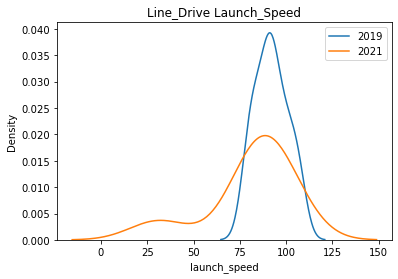

In [54]:
sns.distplot(ld_19[ld_19['events']=='field_out']['launch_speed'],hist=False, label='2019')
sns.distplot(ld_21[ld_21['events']=='field_out']['launch_speed'],hist=False, label='2021')
plt.title('Line_Drive Launch_Speed')
plt.legend()
plt.show()

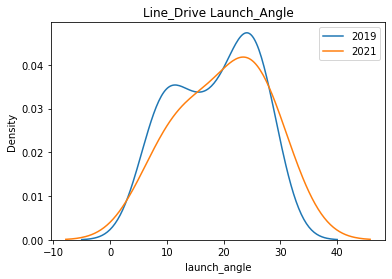

In [55]:
sns.distplot(ld_19[ld_19['events']=='field_out']['launch_angle'],hist=False, label='2019')
sns.distplot(ld_21[ld_21['events']=='field_out']['launch_angle'],hist=False, label='2021')
plt.title('Line_Drive Launch_Angle')
plt.legend()
plt.show()

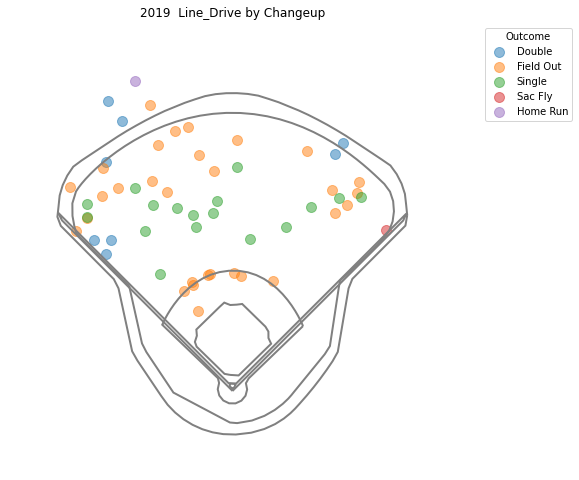

<Axes:title={'center':'2019  Line_Drive by Changeup'}>

In [59]:
pyb.spraychart(ld_19, 'dodgers', title='2019  Line_Drive by Changeup')

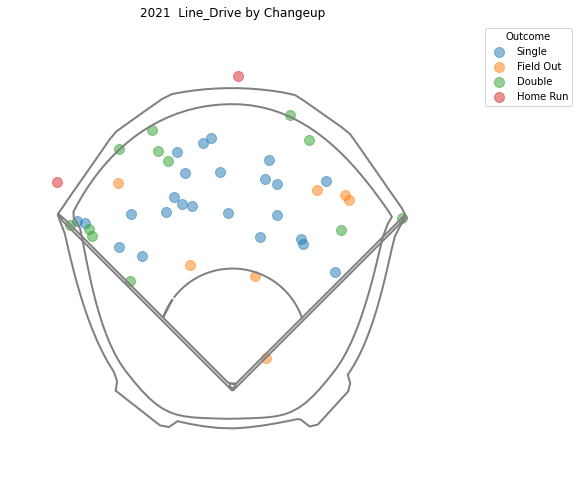

<Axes:title={'center':'2021  Line_Drive by Changeup'}>

In [60]:
pyb.spraychart(ld_21, 'blue_jays', title='2021  Line_Drive by Changeup')